<a href="https://colab.research.google.com/github/qazalmehrban/Medical-Segmentation/blob/ghazal/kera_dataloader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [64]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from skimage.transform import resize
import numpy as np
import nibabel as nib
import os 

import matplotlib.pyplot as plt


In [ ]:
heaight, width = 200,200

In [65]:
samples = '/content/drive/MyDrive/samples/'
patients = next(os.walk(samples))[2]
labels = '/content/drive/MyDrive/segmentation/'
segmentations =next(os.walk(labels))[2]


In [72]:
segmentations.sort()
segmentations

['Case00_segmentation.nii.gz',
 'Case01_segmentation.nii.gz',
 'Case02_segmentation.nii.gz',
 'Case03_segmentation.nii.gz',
 'Case04_segmentation.nii.gz',
 'Case05_segmentation.nii.gz',
 'Case06_segmentation.nii.gz',
 'Case07_segmentation.nii.gz',
 'Case08_segmentation.nii.gz',
 'Case09_segmentation.nii.gz',
 'Case10_segmentation.nii.gz',
 'Case11_segmentation.nii.gz',
 'Case12_segmentation.nii.gz',
 'Case13_segmentation.nii.gz',
 'Case14_segmentation.nii.gz',
 'Case15_segmentation.nii.gz',
 'Case16_segmentation.nii.gz',
 'Case17_segmentation.nii.gz',
 'Case18_segmentation.nii.gz',
 'Case19_segmentation.nii.gz',
 'Case20_segmentation.nii.gz',
 'Case21_segmentation.nii.gz',
 'Case22_segmentation.nii.gz',
 'Case23_segmentation.nii.gz',
 'Case24_segmentation.nii.gz',
 'Case25_segmentation.nii.gz',
 'Case26_segmentation.nii.gz',
 'Case27_segmentation.nii.gz',
 'Case28_segmentation.nii.gz',
 'Case29_segmentation.nii.gz',
 'Case30_segmentation.nii.gz',
 'Case31_segmentation.nii.gz',
 'Case32

In [76]:
patients.sort()
patients

['Case00.nii.gz',
 'Case01.nii.gz',
 'Case02.nii.gz',
 'Case03.nii.gz',
 'Case04.nii.gz',
 'Case05.nii.gz',
 'Case06.nii.gz',
 'Case07.nii.gz',
 'Case08.nii.gz',
 'Case09.nii.gz',
 'Case10.nii.gz',
 'Case11.nii.gz',
 'Case12.nii.gz',
 'Case13.nii.gz',
 'Case14.nii.gz',
 'Case15.nii.gz',
 'Case16.nii.gz',
 'Case17.nii.gz',
 'Case18.nii.gz',
 'Case19.nii.gz',
 'Case20.nii.gz',
 'Case21.nii.gz',
 'Case22.nii.gz',
 'Case23.nii.gz',
 'Case24.nii.gz',
 'Case25.nii.gz',
 'Case26.nii.gz',
 'Case27.nii.gz',
 'Case28.nii.gz',
 'Case29.nii.gz',
 'Case30.nii.gz',
 'Case31.nii.gz',
 'Case32.nii.gz',
 'Case33.nii.gz',
 'Case34.nii.gz',
 'Case35.nii.gz',
 'Case36.nii.gz',
 'Case37.nii.gz',
 'Case38.nii.gz',
 'Case39.nii.gz',
 'Case40.nii.gz',
 'Case41.nii.gz',
 'Case42.nii.gz',
 'Case43.nii.gz',
 'Case44.nii.gz',
 'Case45.nii.gz',
 'Case46.nii.gz',
 'Case47.nii.gz',
 'Case48.nii.gz',
 'Case49.nii.gz',
 'Case50.nii.gz',
 'Case51.nii.gz',
 'Case52.nii.gz']

In [67]:
def make_box(mask):
    box = []
    obj_ids = np.unique(mask)
    if mask.dtype == bool:
        if len(np.unique(mask))==2:
            
            y_min = np.nonzero(mask)[0].min()
            y_max = np.nonzero(mask)[0].max()
            x_min = np.nonzero(mask)[1].min()
            x_max = np.nonzero(mask)[1].max()
            box.append([x_min, y_min, x_max, y_max])
    else :
        
        for i in  obj_ids[1:]:
            y_min = np.nonzero(mask==i)[0].min()
            y_max = np.nonzero(mask==i)[0].max()
            x_min = np.nonzero(mask==i)[1].min()
            x_max = np.nonzero(mask==i)[1].max()
            box.append([x_min, y_min, x_max, y_max])
    return dict(zip([f"label{int(i)}" for i in obj_ids[1:]],box))

shape (384, 384, 15)
labels_slice_0 [0. 2.]
bounding_box {'label2': [163, 185, 190, 216]}


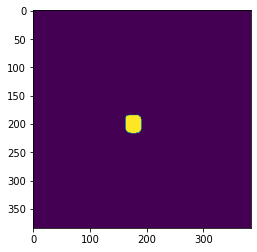

In [73]:
Masks = nib.load((labels + segmentations[0]))    
Masks = np.array(Masks.dataobj)
print('shape', Masks.shape)
slices =0
Masks_2d = Masks[:,:,slices]
print(f'labels_slice_{slices}', np.unique(Masks_2d))
print('bounding_box', make_box(Masks_2d))
plt.imshow(Masks_2d)

shape (384, 384, 15)
labels_slice_1 [0. 1. 2.]
bounding_box {'label1': [169, 179, 203, 217], 'label2': [164, 186, 189, 209]}


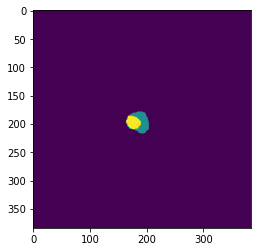

In [74]:
Masks = nib.load((labels + segmentations[0]))    
Masks = np.array(Masks.dataobj)
print('shape', Masks.shape)
slices =1
Masks_2d = Masks[:,:,slices]
print(f'labels_slice_{slices}', np.unique(Masks_2d))
print('bounding_box', make_box(Masks_2d))
plt.imshow(Masks_2d)

shape (512, 512, 29)
labels_slice_0 [0]
bounding_box {}


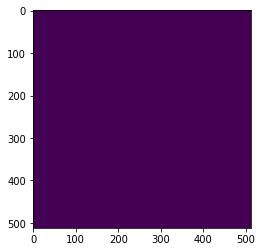

In [75]:
Masks = nib.load((labels + segmentations[1]))    
Masks = np.array(Masks.dataobj)
print('shape', Masks.shape)
slices =0
Masks_2d = Masks[:,:,slices]
print(f'labels_slice_{slices}', np.unique(Masks_2d))
print('bounding_box', make_box(Masks_2d))
plt.imshow(Masks_2d)

In [77]:
crop_size = 160
p_seg = []
p_im = []
for i, i1 in zip(segmentations, patients):
    im = nib.load(os.path.join(img_path, i1))    
    im = np.array(im.dataobj)

    Masks = nib.load(os.path.join(segment_path, i))    
    Masks = np.array(Masks.dataobj)
    Masks.shape
    for  j in range(Masks.shape[2]):
        
        k=make_box(Masks[:,:,j].astype(np.bool))
        if len(k)!=0:
            b_list = k['label1']
            x_min, y_min, x_max, y_max = b_list
            
            length_x = x_max -x_min + 1
            length_y = y_max - y_min + 1
            del_x = crop_size - length_x 
            del_y = crop_size - length_y 

            if del_x%2==0:
                kx = del_x//2
                sx=0
            else:
                kx = del_x//2

                sx = 1
            if del_y%2==0:
                ky = del_y//2
                sy=0
            else:
                ky = del_y//2
                sy = 1
            crop = Masks[ y_min - ky - sy : y_max + ky + 1, x_min - kx - sx : x_max + kx  + 1,j ]
            crop_im = im[ y_min - ky - sy : y_max + ky + 1, x_min - kx - sx : x_max + kx  + 1,j ]
            p_seg.append(crop)
            p_im.append(crop_im)

           
                
            
        
    

FileNotFoundError: ignored

In [ ]:
segment_numpy = np.stack(p_seg,2)
image_numpy = np.stack(p_im, 2)

In [ ]:
train = image_numpy/image_numpy.max()

In [ ]:
tra  = np.transpose(train,(2,0,1))

In [ ]:
seg = np.transpose(segment_numpy,(2,0,1))

In [ ]:
'''
def gen():
  samples = '/content/drive/MyDrive/samples/'
  patients = next(os.walk(samples))[2]
  patients.sort()
  labels = '/content/drive/MyDrive/segmentation/'
  segmentations =next(os.walk(labels))[2]
  segmentations.sort()
  for i,j in zip(patients,segmentations):
    Images = nib.load((samples + i))
    im = np.array(Images.dataobj)
    Masks = nib.load((labels + j))    
    Masks = np.array(Masks.dataobj)
    img_resize = resize(im,
               (IMG_HEIGHT, IMG_WIDTH),
             mode = 'constant',
              anti_aliasing=True,
               preserve_range=True)
    mask_resize = resize(Masks,
               (IMG_HEIGHT, IMG_WIDTH),
             mode = 'constant',
              anti_aliasing=True,
               preserve_range=True)
    for k in range(im.shape[2]):
      im1 = np.expand_dims(img_resize[:,:,k],2)
      ma = np.expand_dims(mask_resize[:,:,k],2)

      yield {'Image':im1, 'Mask':ma}
      
'''

In [ ]:
dat = tf.data.Dataset.from_generator(gen, output_types ={"Image": tf.float32, "Mask": tf.float32}).batch(45)

In [ ]:
it=iter(dat)

In [ ]:
dataset = next(it)

# Model

In [ ]:
img_size = (160, 160)

In [ ]:


def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (1,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model(img_size, 3)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 80, 80, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 80, 80, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 80, 80, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

# train

In [ ]:
# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.h5", save_best_only=True)
]

# Train the model, doing validation at the end of each epoch.
epochs = 15
model.fit(tra, seg, epochs=epochs)

In [ ]:
import os

In [ ]:
root = "home"

In [ ]:
al_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)
val_preds = model.predict(val_gen)



# Display results for validation image #10
i = 10

# Display input image
display(Image(filename=val_input_img_paths[i]))

# Display ground-truth target mask
img = PIL.ImageOps.autocontrast(load_img(val_target_img_paths[i]))
display(img)

# Display mask predicted by our model
display_mask(i)  # Note that the model only sees inputs at 150x150.

In [ ]:

def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)


In [ ]:
pr = model.predict(tra[:670])

In [ ]:
mask1 = np.argmax(pr[20], axis=-1)


In [ ]:
plt.imshow(mask1)

In [ ]:
pr[2]